# Notebook that use for test Molzip with DataPDBbind

---

## Summary

- Preparation of the data

- Application with dataPDB (only the line with Kd)

    We have different value of affinity in this dataset and we want to use the ligand-pocket that use the same metric (here Kd)

    In the dataset of PDBBind, they already split the data train/test, and we want to try it to see if it's work.

    - (Cross validation) Prediction of "value" in dataPDB to see if molzip is working
    - (Cross validation) Prediction of "Kd" in dataPDB to see if molzip is working
    - Prediction of "value" with the split of the data
    - Prediction of "kd/ki" with the split of the data

- Application with all the dataPDB
    - Prediction of "value" with all the database of PDBbind with k = 1
    - Prediction of "value" with all the database of PDBbind with k = 10
    - Prediction with the categorization of Kd

In [3]:
from molzip_adapted import regression_one, regression, projection
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import choice
from numpy import column_stack
from sklearn.decomposition import PCA
import numpy as np
import gzip
import time

## Preparation of the data

In [15]:
path_data = "../data/"
data_pdb = pd.read_csv(path_data+"LP_PDBBind.csv")
data_pdb = data_pdb.dropna()
# Data that we prepross to have categories of kd
data_kd_cat = pd.read_csv(path_data+"datatest.csv")

In [7]:
def split_data(data,nb_split):
    # split des train et test
    nb_data = len(data)
    list_ = list(np.arange(nb_data))
    liste_train = []
    liste_test = []
    pas = nb_data//nb_split

    for i in range(nb_split):
        liste_train.append(list_[0:i*pas]+list_[(i+1)*pas:])
        liste_test.append(list_[i*pas:(i+1)*pas])

    return liste_train,liste_test



In [26]:
# Sorting the dataPDB to only have Kd
liste_ligne_kd = []
liste_kd = []
data_pdb_kd = pd.DataFrame()
data_pdb_kd["ID"] = data_pdb["Unnamed: 0"]
data_pdb_kd["smiles"] = data_pdb["smiles"]
data_pdb_kd["seq"] = data_pdb["seq"]
data_pdb_kd["value"] = data_pdb["value"]

for i,kd in zip(data_pdb.index,data_pdb["kd/ki"]):
    if kd[:2] == "Kd":

        value = 0
        # In the case there are ">=" or "<="
        if kd[3]=="=":
            value = float(kd[4:-2])
        else :
            value = float(kd[3:-2])

        # Convert everything to the same unit
        if kd[-2:] == 'mM':
            liste_kd.append(value*1e6)
        elif kd[-2:] == 'uM':
            liste_kd.append(value*1e3)
        elif kd[-2:] == 'nM':
            liste_kd.append(value)
        elif kd[-2:] == 'pM':
            liste_kd.append(value*1e-3)
        elif kd[-2:] == 'fM':
            liste_kd.append(value*1e-6)

    # If it is not a Kd value
    else:
        data_pdb_kd = data_pdb_kd.drop(i)

data_pdb_kd["kd"] = liste_kd
data_pdb_kd.index = np.arange(len(data_pdb_kd))

In [27]:
# Concatenation des ligand et des pockets
liste_complexe_kd = []
liste_complexe_kd_zip = []
liste_complexe_kd_len_zip = []

for ligand, seq in zip(data_pdb_kd["smiles"],data_pdb_kd["seq"]):
    liste_complexe_kd.append(ligand+seq)
    liste_complexe_kd_zip.append(gzip.compress((ligand+seq).encode()))
    liste_complexe_kd_len_zip.append(len(gzip.compress((ligand+seq).encode())))

liste_complexe_kd_len_zip = np.array(liste_complexe_kd_len_zip)
liste_complexe_kd_zip = np.array(liste_complexe_kd_zip)
liste_complexe_kd = np.array(liste_complexe_kd)


data_pdb_kd["lig+seq"]=liste_complexe_kd
data_pdb_kd["zip"]=liste_complexe_kd_zip
data_pdb_kd["len_zip"]=liste_complexe_kd_len_zip
data_pdb_kd.to_csv("data_PDB_Kd.csv")

## Application with dataPDB (only the line with Kd)

### (Cross validation) Prediction of "value" in dataPDB to see if molzip is working

In [ ]:
nb_split = 10
liste_train,liste_test = split_data(data_pdb_kd, nb_split)
liste_labels = np.array(data_pdb_kd["value"])

# Cross validation avec notre propre split
liste_pred = []
for i in range(nb_split):
    X_train = liste_complexe_kd[liste_train[i]]
    X_test = liste_complexe_kd[liste_test[i]]
    Y_train = liste_labels[liste_train[i]]
    pred = regression(X_test, X_train, Y_train, k=1)
    liste_pred.append(pred)


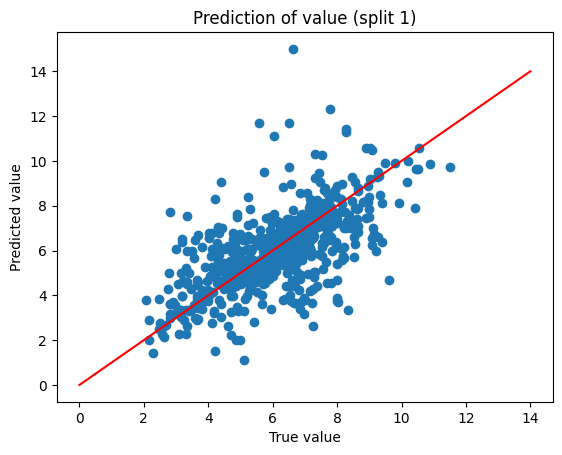

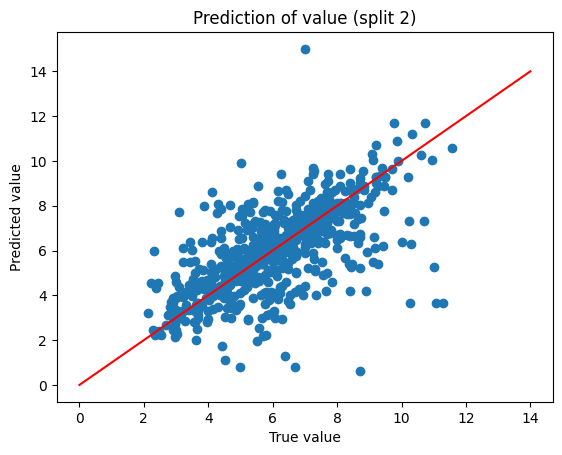

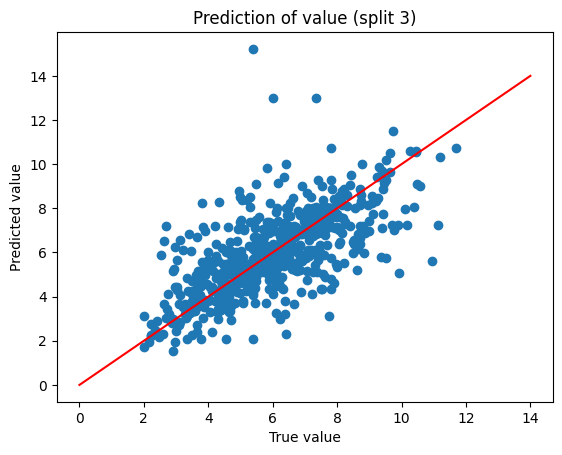

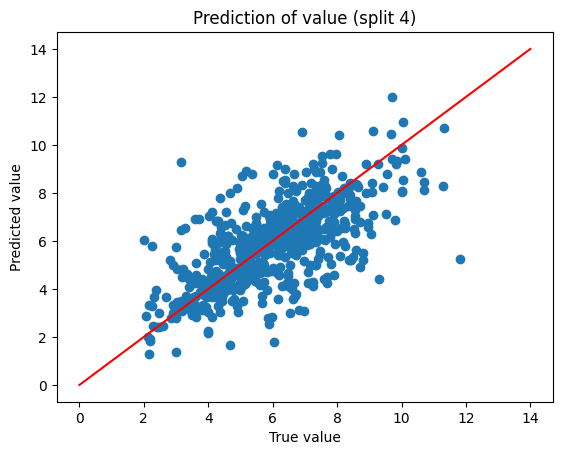

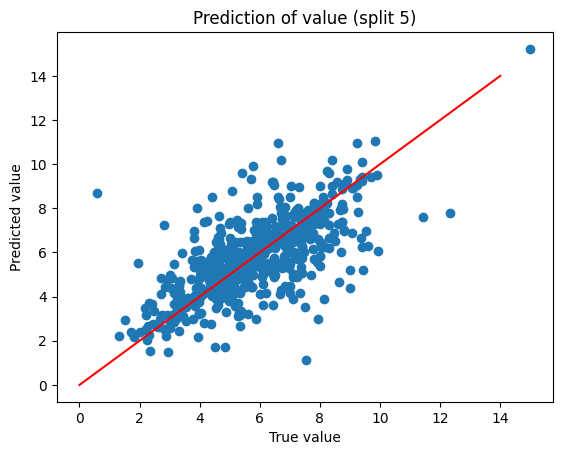

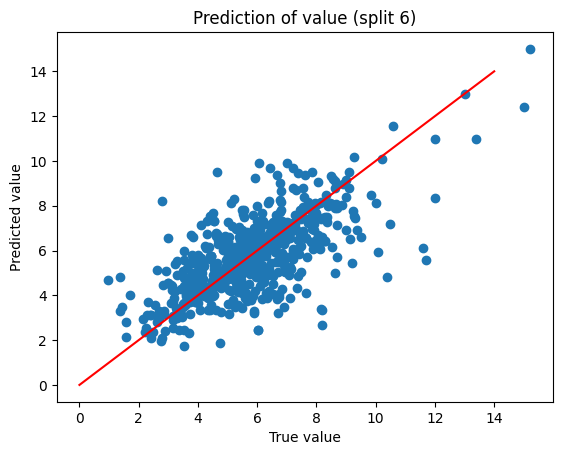

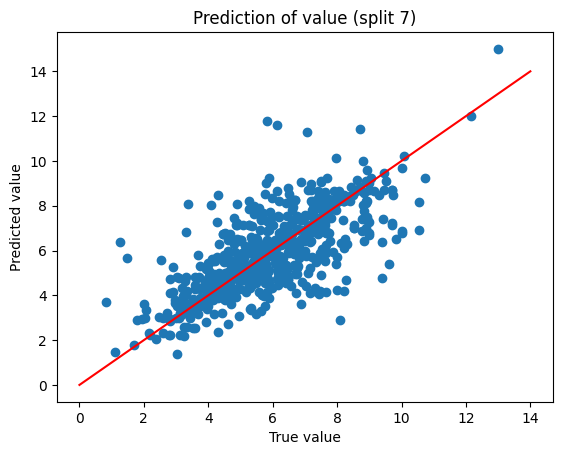

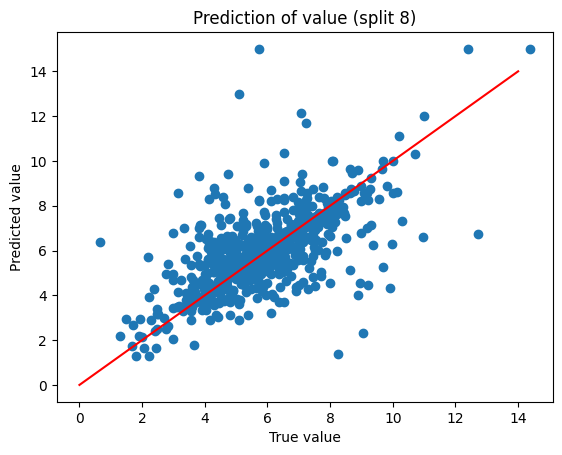

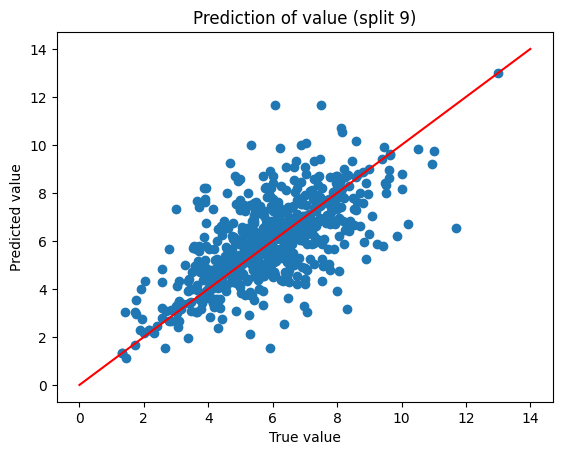

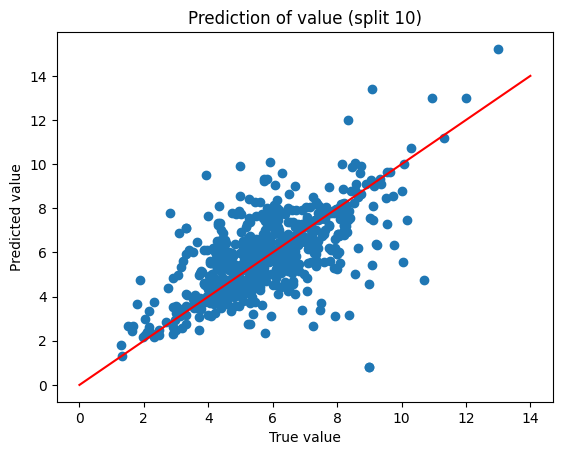

In [ ]:
for i in range(nb_split):
    plt.figure()
    plt.scatter(liste_labels[liste_test[i]],liste_pred[i])
    plt.title("Prediction of value (split %d)"%(i+1))
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.plot([0,14],[0,14],c='red')
    plt.show()

### (Cross validation) Prediction of "Kd" in dataPDB to see if molzip is working

In [ ]:
liste_labels2 = np.array(data_pdb_kd["kd"])

# Cross validation avec notre propre split
liste_pred2 = []
for i in range(nb_split):
    X_train = liste_complexe_kd[liste_train[i]]
    X_test = liste_complexe_kd[liste_test[i]]

    Y_train = liste_labels2[liste_train[i]]
    pred = regression(X_test, X_train, Y_train, k=1)
    liste_pred2.append(pred)

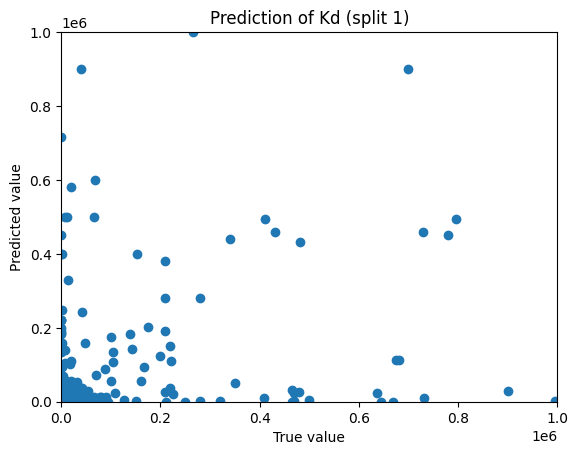

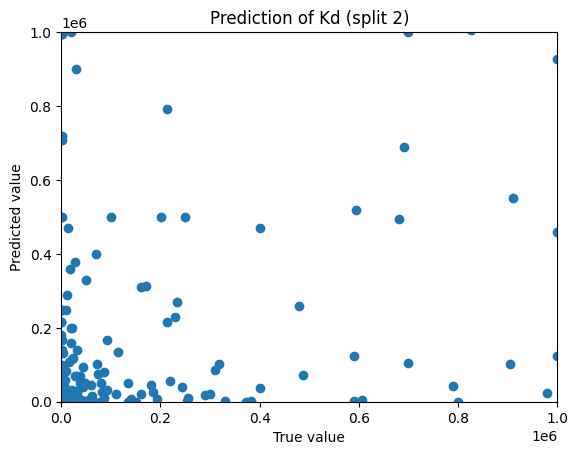

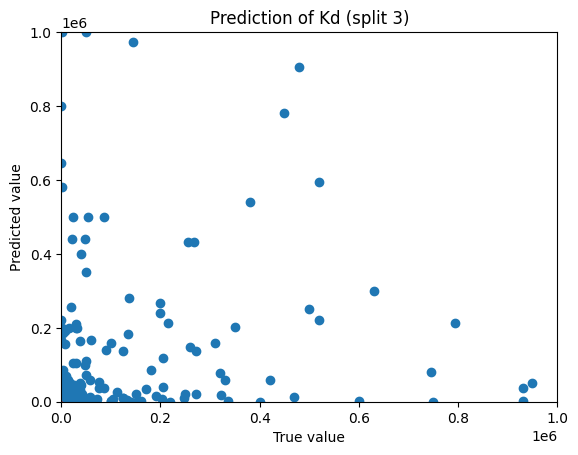

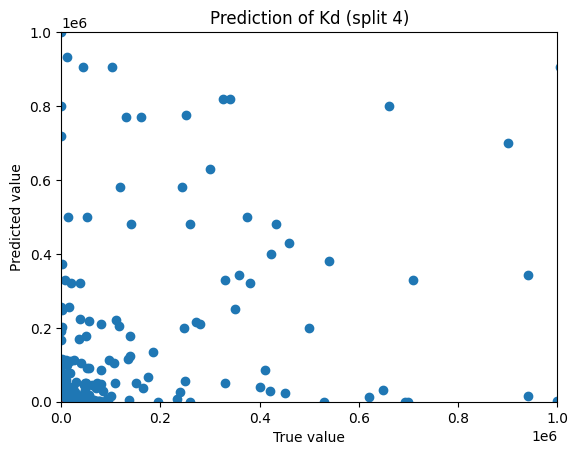

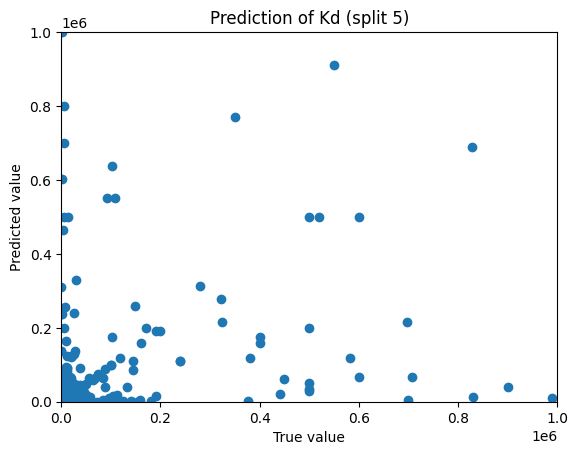

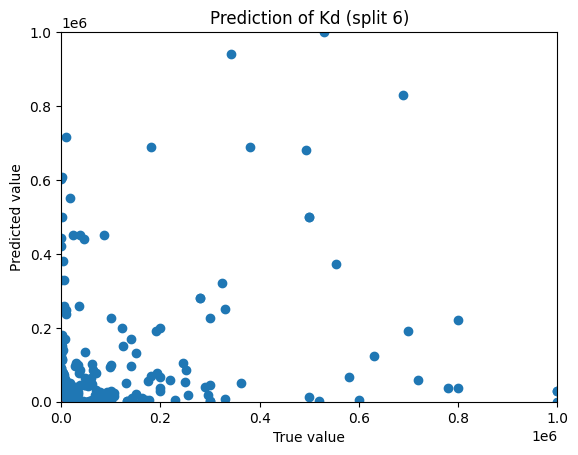

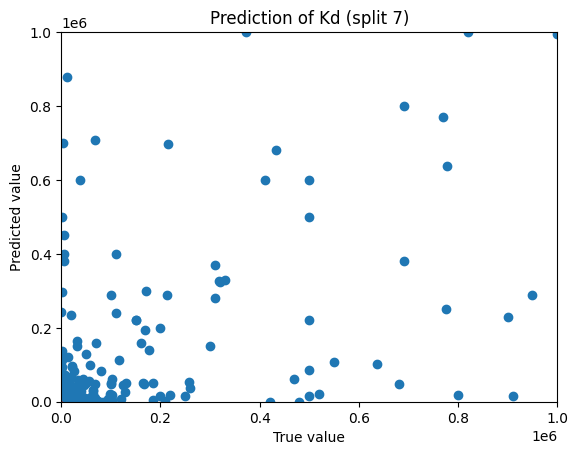

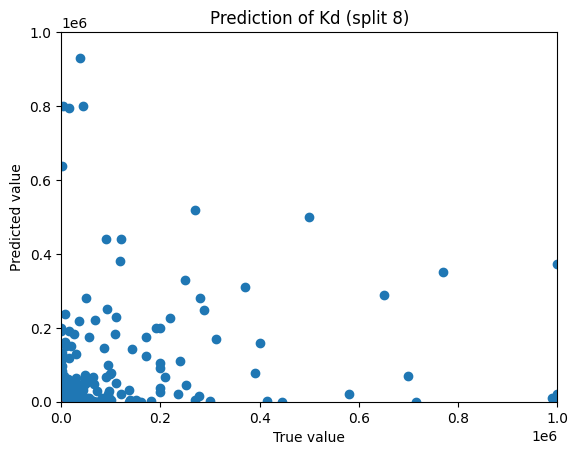

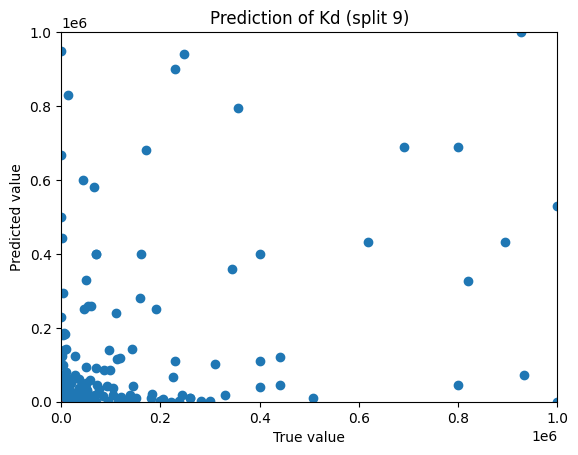

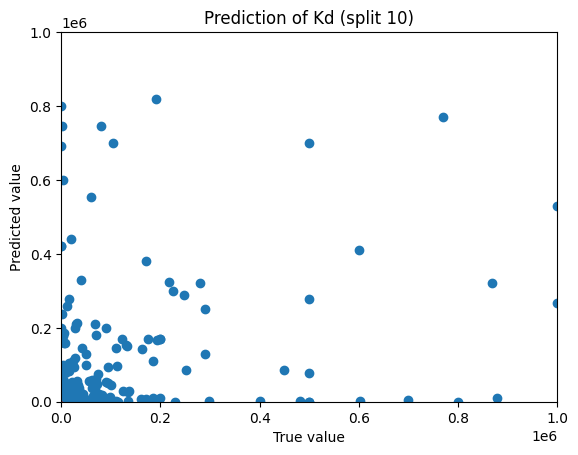

In [ ]:
for i in range(nb_split):
    plt.figure()
    plt.scatter(liste_labels2[liste_test[i]],liste_pred2[i])
    plt.title("Prediction of Kd (split %d)"%(i+1))
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.xlim([-10,1e6])
    plt.ylim([-10,1e6])
    plt.plot([0,14],[0,14],c='red')
    plt.show()

### Prediction of "value" with the split of the data

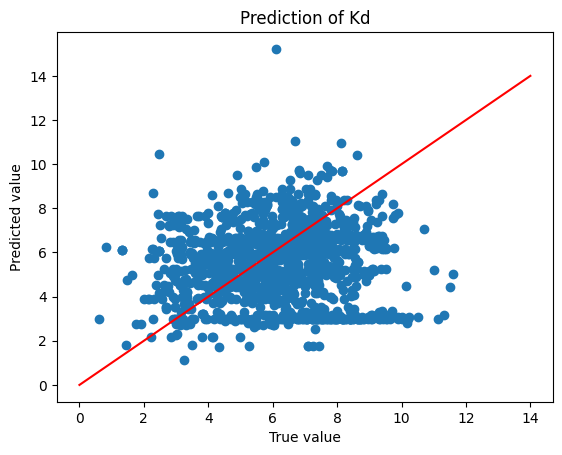

In [ ]:
liste_labels = np.array(data_pdb_kd["value"])

# Split of the dataPDBbind
index_train = data_pdb_kd["new_split"]=="train"
index_test = data_pdb_kd["new_split"]=="test"

X_train = liste_complexe_kd[index_train]
X_test = liste_complexe_kd[index_test]
Y_train = liste_labels[index_train]
pred1 = regression(X_test, X_train, Y_train, k=1)

plt.figure()
plt.scatter(liste_labels[index_test],pred1)
plt.title("Prediction of Kd")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.plot([0,14],[0,14],c='red')
plt.show()

### Prediction of "kd/ki" with the split of the data

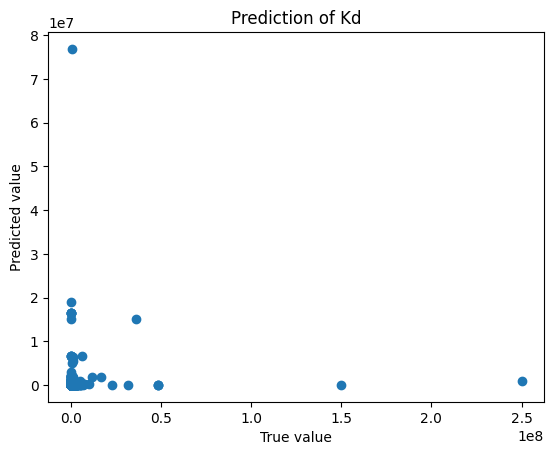

In [ ]:
liste_labels = np.array(data_pdb_kd["kd"])

# Split of the dataPDBbind
index_train = data_pdb_kd["new_split"]=="train"
index_test = data_pdb_kd["new_split"]=="test"

X_train = liste_complexe_kd[index_train]
X_test = liste_complexe_kd[index_test]
Y_train = liste_labels[index_train]
pred2 = regression(X_test, X_train, Y_train, k=1)

plt.figure()
plt.scatter(liste_labels[index_test],pred2)
plt.title("Prediction of Kd")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.plot([0,14],[0,14],c='red')
plt.show()

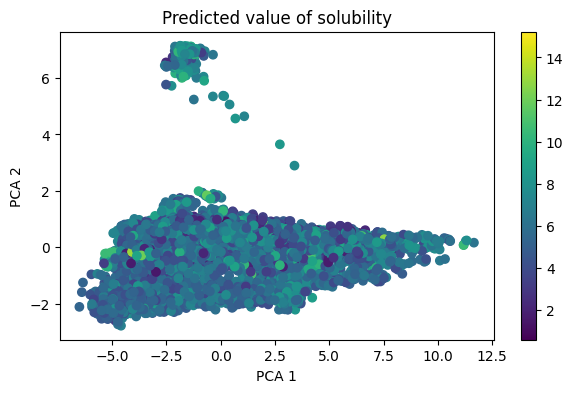

In [ ]:
liste_labels = np.array(data_pdb_kd["value"])
proj = projection(liste_complexe_kd)


fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(7)
color = ax.scatter(proj[:, 0], proj[:, 1], c=liste_labels)
fig.colorbar(color)
plt.title("Predicted value")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

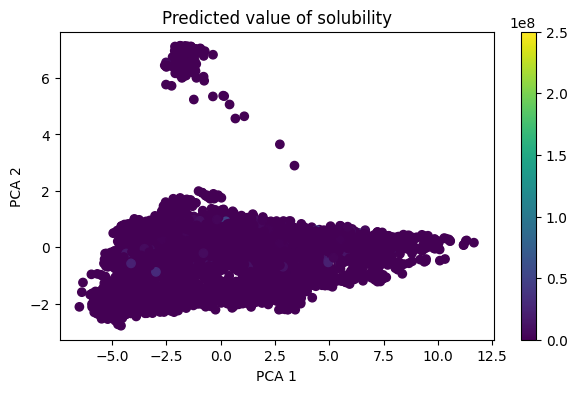

In [ ]:
liste_labels = np.array(data_pdb_kd["kd"])
proj = projection(liste_complexe_kd)


fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(7)
color = ax.scatter(proj[:, 0], proj[:, 1], c=liste_labels)
fig.colorbar(color)
plt.title("Predicted value")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

## Application with all the dataPDB

### Prediction of "value" with all the database of PDBbind with k = 1

In [14]:
# split of train and test
nb_split = 10
liste_train,liste_test = split_data(data_pdb, nb_split)

# Concatenation of the ligand and the pockets
liste_complexe = []


for ligand, seq in zip(data_pdb["smiles"],data_pdb["seq"]):
    liste_complexe.append(ligand+seq)

liste_complexe = np.array(liste_complexe)


In [3]:
liste_labels = np.array(data_pdb["value"])

# Cross validation with our split
liste_pred = []
for i in range(2):
    X_train = liste_complexe[liste_train[i]]
    X_test = liste_complexe[liste_test[i]]

    Y_train = liste_labels[liste_train[i]]
    pred = regression(X_test, X_train, Y_train, k=1)
    liste_pred.append(pred)


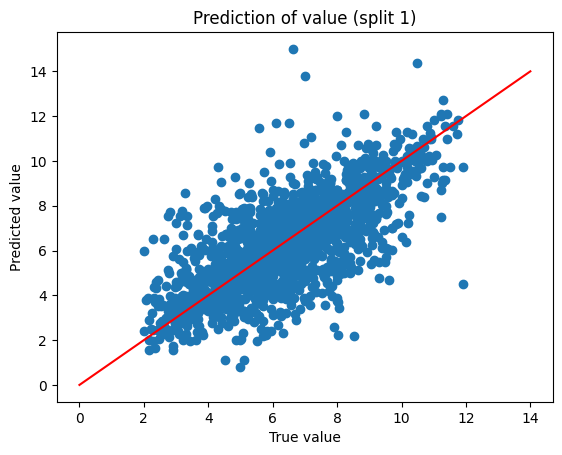

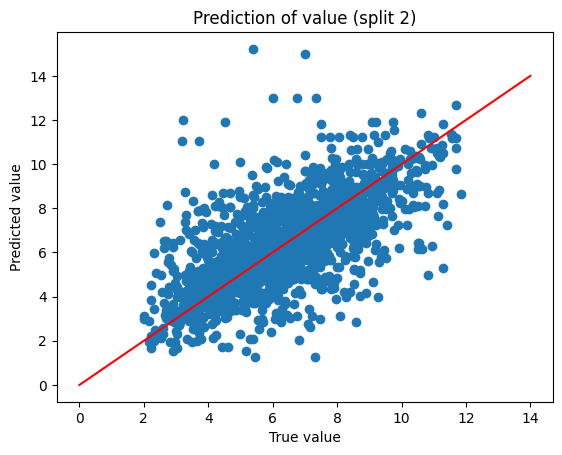

In [76]:
for i in range(2):
    plt.figure()
    plt.scatter(liste_labels[liste_test[i]],liste_pred[i])
    plt.title("Prediction of value (split %d)"%(i+1))
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.plot([0,14],[0,14],c='red')
    plt.show()

### Prediction of "value" with all the database of PDBbind with k = 10

In [3]:
nb_split = 10
liste_train,liste_test = split_data(data_pdb, nb_split)
liste_labels = np.array(data_pdb["value"])

# Cross validation avec notre propre split
liste_pred = []
for i in range(nb_split):
    X_train = liste_complexe[liste_train[i]]
    X_test = liste_complexe[liste_test[i]]
    Y_train = liste_labels[liste_train[i]]
    pred = regression(X_test, X_train, Y_train, k=10)
    liste_pred.append(pred)


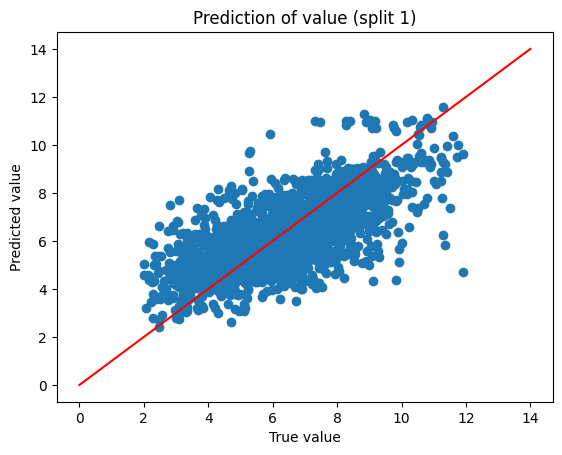

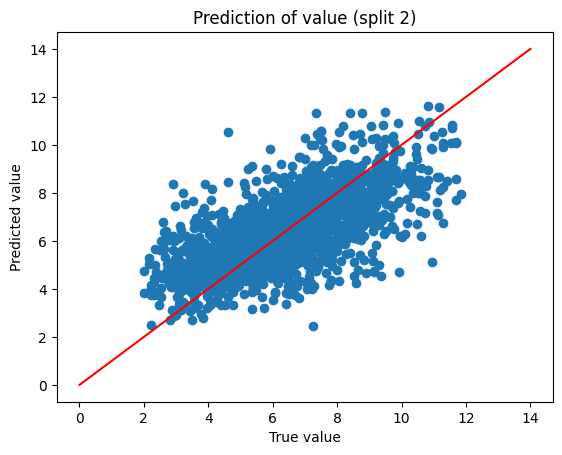

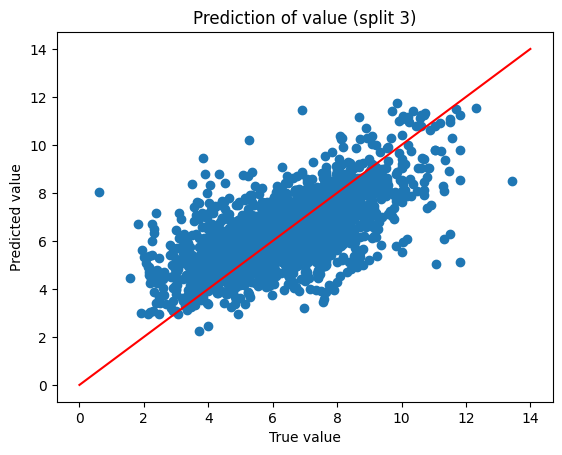

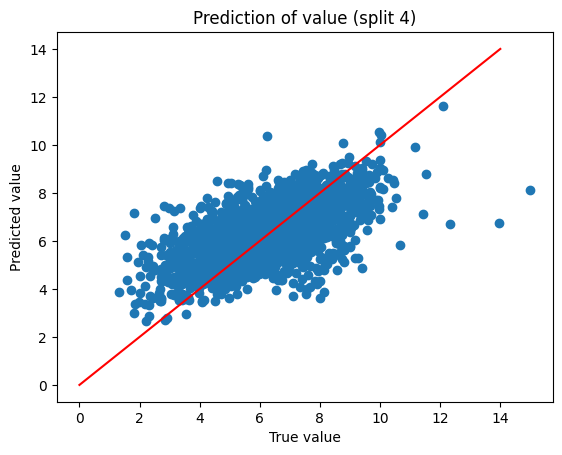

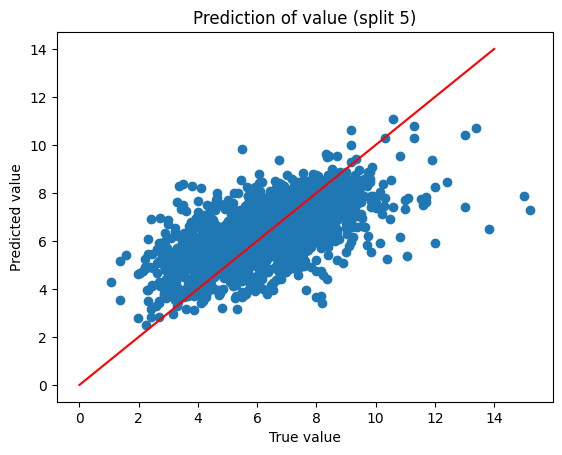

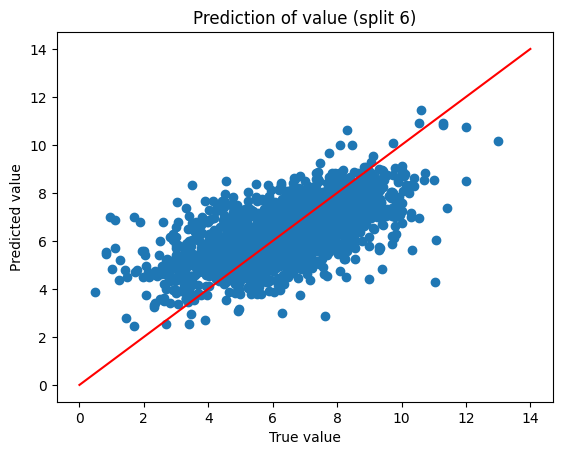

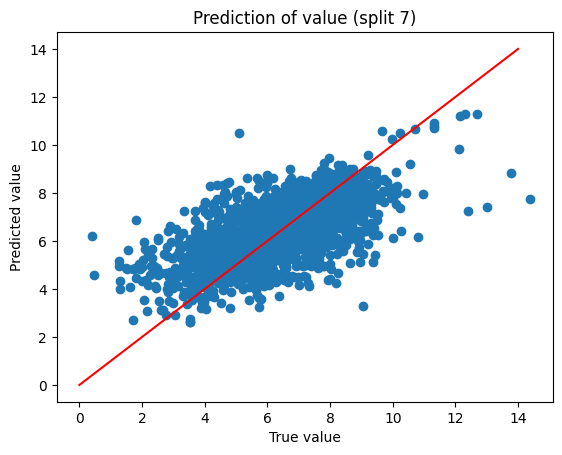

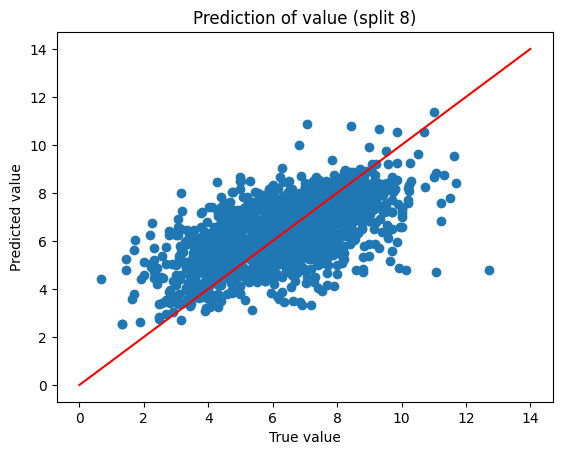

In [23]:
for i in range(nb_split):
    plt.figure()
    plt.scatter(liste_labels[liste_test[i]],liste_pred[i])
    plt.title("Prediction of value (split %d)"%(i+1))
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.plot([0,14],[0,14],c='red')
    plt.show()